<a href="https://colab.research.google.com/github/jihoo1018/project/blob/main/contextencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time


if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'


In [ ]:
import os
if not os.path.isfile("/content/voc_test_2007_tar"):
  !cp "/content/drive/MyDrive/Faster_RCNN/VOCtest_06-Nov-2007.tar" "/content/voc_test_2007_tar" 
  ! tar -xf "/content/voc_test_2007_tar"

In [ ]:
import os
if not os.path.isfile("/content/city.zip"):
  !cp "/content/drive/MyDrive/Inpainting/city.zip" "/content/city.zip" 
  ! unzip "/content/city.zip" -d "/content/city"

if not os.path.isfile("/content/nature.zip"):
  !cp "/content/drive/MyDrive/Inpainting/nature.zip" "/content/nature.zip" 
  ! unzip "/content/nature.zip" -d "/content/nature"

Archive:  /content/city.zip
  inflating: /content/city/000001_0.jpg  
  inflating: /content/city/000001_1.jpg  
  inflating: /content/city/000001_2.jpg  
  inflating: /content/city/000001_3.jpg  
  inflating: /content/city/000001_4.jpg  
  inflating: /content/city/000001_5.jpg  
  inflating: /content/city/000002_0.jpg  
  inflating: /content/city/000002_1.jpg  
  inflating: /content/city/000002_2.jpg  
  inflating: /content/city/000002_3.jpg  
  inflating: /content/city/000002_4.jpg  
  inflating: /content/city/000002_5.jpg  
  inflating: /content/city/000003_0.jpg  
  inflating: /content/city/000003_1.jpg  
  inflating: /content/city/000003_2.jpg  
  inflating: /content/city/000003_3.jpg  
  inflating: /content/city/000003_4.jpg  
  inflating: /content/city/000003_5.jpg  
  inflating: /content/city/000004_0.jpg  
  inflating: /content/city/000004_1.jpg  
  inflating: /content/city/000004_2.jpg  
  inflating: /content/city/000004_3.jpg  
  inflating: /content/city/000004_4.jpg  
  infl

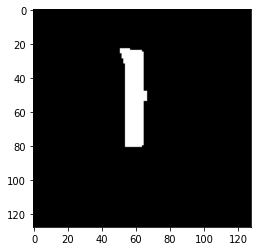

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def make_mask(size):
  label = 0
  while True:
    seg_list = os.listdir("/content/VOCdevkit/VOC2007/SegmentationObject/")
    seg_image = Image.open("/content/VOCdevkit/VOC2007/SegmentationObject/"+seg_list[np.random.randint(0,len(seg_list))])
    seg_image = seg_image.resize((size,size))
    np_seg = np.array(seg_image,dtype=np.uint8)
    labels = np.unique(np_seg)

    for lb in labels[1:-1]:
      if len(np.where(np_seg == lb)[0]) < (size**2)/4:
        label = lb
        break

    if label != 0:
      break

  np_seg = np.where(np_seg == label,1.0,0)
  np_seg = np.stack((np_seg,np_seg,np_seg),axis = 2)

  return np_seg

plt.imshow(make_mask(128))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time


class Data(Dataset):
  def __init__(self, size= 128):
    self.city_list = os.listdir("/content/city/")
    self.nature_list = os.listdir("/content/nature")
    self.every_list = []
    self.to_tensor = transforms.ToTensor()
    self.size = size

    for x in self.city_list:
      self.every_list.append("/content/city/"+x)
    for x in self.nature_list:
      self.every_list.append("/content/nature/"+x)
    
    self.every_list.sort()

  def __len__(self):
    return len(self.every_list)
  
  def __getitem__(self,idx):
    mask = make_mask(self.size)
    image = Image.open(self.every_list[idx]).convert("RGB")

    image = image.crop((100,200,image.size[0],image.size[1]))
    image = image.resize((self.size,self.size))
    image = np.array(image,dtype=np.uint8)
    image = image/255

    #The missing region in the masked input image is filled with constant mean value.
    masked_image = (1-mask)*image + mask*(np.zeros_like(image)+np.mean(image))
    
    return self.to_tensor(masked_image).type(torch.float32), self.to_tensor(mask).type(torch.float32), self.to_tensor(image).type(torch.float32)
  


In [ ]:
from Data import Data
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#Dataloader 테스트
dataset = Dataloading(128)
dataloader = DataLoader(dataset,shuffle=True)
for a,b,c in dataloader:
  break
print(a.shape)
fig = plt.figure(figsize=(13,4))
fig.add_subplot(1,3,1)
plt.imshow(a.squeeze(0).permute(1,2,0),aspect='auto')
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(b.squeeze(0).permute(1,2,0),aspect='auto')
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(c.squeeze(0).permute(1,2,0),aspect='auto')
plt.axis('off')




ModuleNotFoundError: ignored